# Dependancies

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=(RuntimeWarning, FutureWarning, UserWarning))

import gc
import time
import os
import urllib.request
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
from io import BytesIO
from matplotlib.pyplot import subplots
import tensorflow as tf
import keras
from keras import layers, Model
from keras.models import Sequential
from keras.layers import Layer, Dense, Activation, Dropout, Input, concatenate, Average, Concatenate, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, ZeroPadding2D, GaussianNoise
from keras.optimizers import Adam
from keras.utils import array_to_img
from keras.callbacks import Callback
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy


In [2]:
np.random.seed(0)
tf.random.set_seed(0)

IN_COLAB = os.getenv("COLAB_RELEASE_TAG") is not None

AUTOTUNE = tf.data.AUTOTUNE

print("tf version: ", tf.__version__)

tf version:  2.12.0


In [3]:
# from google.colab import files
# from google.colab import drive

# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
url = 'https://raw.githubusercontent.com/mit-han-lab/data-efficient-gans/master/DiffAugment-stylegan2/DiffAugment_tf.py'
filename = 'DiffAugment_tf.py'
urllib.request.urlretrieve(url, filename)
import DiffAugment_tf

function_names = [name for name in dir(DiffAugment_tf) if callable(getattr(DiffAugment_tf, name))]
print("DiffAugment functions:\n", function_names)

DiffAugment functions:
 ['DiffAugment', 'rand_brightness', 'rand_contrast', 'rand_cutout', 'rand_saturation', 'rand_translation']


# Data collection

In [5]:
# !unzip /content/drive/MyDrive/Colab\ Notebooks/Monet/monet_jpg.zip -d /content/drive/MyDrive/Colab\ Notebooks/Monet/monet_jpg
# !unzip /content/drive/MyDrive/Colab\ Notebooks/Monet/photo_jpg.zip -d /content/drive/MyDrive/Colab\ Notebooks/Monet/photo_jpg

In [6]:
photo_path_jpg = "/content/drive/MyDrive/Colab Notebooks/Monet/photo_jpg"
monet_path_jpg = "/content/drive/MyDrive/Colab Notebooks/Monet/monet_jpg"

photo_files_jpg = tf.io.gfile.glob(f"{photo_path_jpg}/*.jpg")
monet_files_jpg = tf.io.gfile.glob(f"{monet_path_jpg}/*.jpg")

# Data Analysis

In [7]:
print('Photo .jpg files count:', len(photo_files_jpg))
print('Monet .jpg files count:', len(monet_files_jpg))

Photo .jpg files count: 7038
Monet .jpg files count: 300


# Data visualization

In [8]:
def plot_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def open_and_plot_image(image_path):
    image = Image.open(image_path)
    plot_image(image)

Photo:


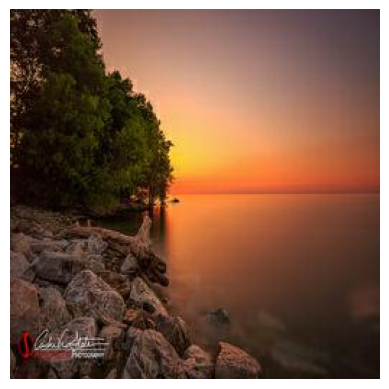

In [9]:
print('Photo:')
open_and_plot_image(os.path.join(photo_path_jpg, photo_files_jpg[0]))

Monet:


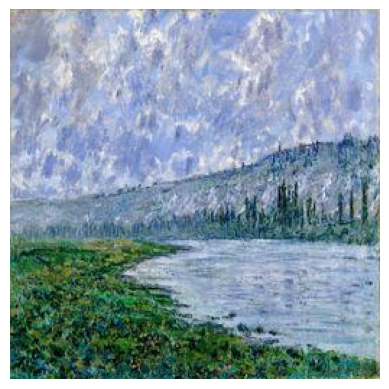

In [10]:
print('Monet:')
open_and_plot_image(os.path.join(monet_path_jpg, monet_files_jpg[0]))

# Data preprocessing

In [11]:
BATCH_SIZE = 2
BUFFER_SIZE = 256
TEST_BATCH_SIZE = 32

In [12]:
def decode_image(image):
    shape = [256, 256, 3]
    image = tf.image.decode_jpeg(tf.io.read_file(image), channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, shape)
    return image

def load_dataset(filenames):
    dataset = tf.data.Dataset.from_tensor_slices(filenames)
    dataset = dataset.map(decode_image, num_parallel_calls=AUTOTUNE)
    return dataset

def data_augment(image):
    image = tf.image.resize(image, [286, 286])
    image = tf.image.random_crop(image, size=[BATCH_SIZE, 256, 256, 3])
    image = tf.image.random_flip_left_right(image)
    return image

In [13]:
def prepare_gan_ds(photo_files, monet_files, augment_fn=None, repeat=True, shuffle=True, cache=True, batch_size=1):
    monet_ds = load_dataset(monet_files)
    photo_ds = load_dataset(photo_files)
    if cache:
        monet_ds = monet_ds.cache()
        photo_ds = photo_ds.cache()
    if repeat:
        monet_ds = monet_ds.repeat()
        photo_ds = photo_ds.repeat()
    if shuffle:
        monet_ds_entries = monet_ds.reduce(0, lambda x,_: x+1).numpy()
        photo_ds_entries = photo_ds.reduce(0, lambda x,_: x+1).numpy()
        monet_ds = monet_ds.shuffle(monet_ds_entries)
        photo_ds = photo_ds.shuffle(photo_ds_entries)
    monet_ds = monet_ds.batch(batch_size)
    photo_ds = photo_ds.batch(batch_size)
    if augment_fn:
        monet_ds = monet_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
        photo_ds = photo_ds.map(augment_fn, num_parallel_calls=AUTOTUNE)
    monet_ds = monet_ds.prefetch(AUTOTUNE)
    photo_ds = photo_ds.prefetch(AUTOTUNE)
    gan_ds = tf.data.Dataset.zip((photo_ds, monet_ds))
    return gan_ds

In [14]:
train_ds = prepare_gan_ds(
    photo_files_jpg,
    monet_files_jpg,
    augment_fn=data_augment,
    repeat=True,
    shuffle=False,
    cache=False,
    batch_size=BATCH_SIZE
)
test_photo_ds = load_dataset(photo_files_jpg).batch(TEST_BATCH_SIZE).prefetch(TEST_BATCH_SIZE)
train_ds.element_spec, test_photo_ds.element_spec

((TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None)),
 TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))

Check datasets

In [15]:
random_photo_image, random_monet_image = next(iter(train_ds.take(1)))
random_photo_image_test = next(iter(test_photo_ds.take(1)))
print('Photo image pixel range: min: {0:.2f}, max: {1:.2f}'.format(random_photo_image.numpy().min(), random_photo_image.numpy().max()))
print('Monet image pixel range: min: {0:.2f}, max: {1:.2f}'.format(random_monet_image.numpy().min(), random_monet_image.numpy().max()))
print('Photo (test) image pixel range: min: {0:.2f}, max: {1:.2f}'.format(random_photo_image_test.numpy().min(), random_photo_image_test.numpy().max()))

Photo image pixel range: min: -1.00, max: 1.00
Monet image pixel range: min: -1.00, max: 1.00
Photo (test) image pixel range: min: -1.00, max: 1.00


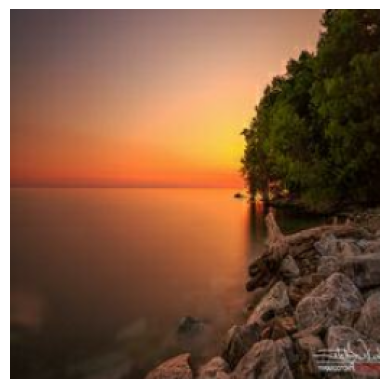

In [16]:
plot_image((random_photo_image[0]+1)/2)

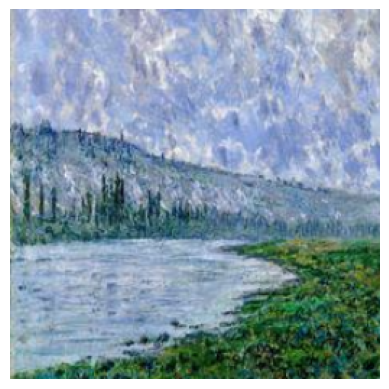

In [17]:
plot_image((random_monet_image[0]+1)/2)

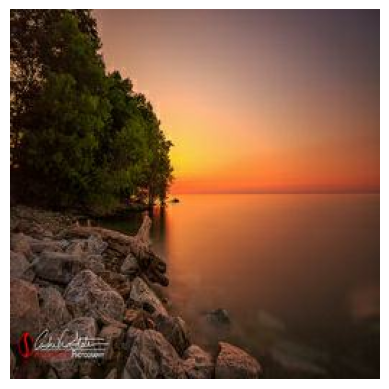

In [18]:
plot_image((random_photo_image_test[0]+1)/2)

In [19]:
del random_photo_image, random_monet_image, random_photo_image_test

In [20]:
gc.collect()

4246

# Model training and evaluation

In [21]:
def diffaug_fn(image):
    return DiffAugment_tf.DiffAugment(image, "color,translation,cutout")

## Generator and Discriminator


In [22]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

Create functions to construct the generator and discriminator.

In [23]:
def downsample(filters, size, apply_instancenorm=True, add_noise=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if add_noise:
        result.add(GaussianNoise(0.2))
    if apply_instancenorm:
        result.add(InstanceNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2,
                               padding='same',
                               kernel_initializer=initializer,
                               use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

In [24]:
def create_generator():
    inputs = Input(shape=[256,256,3])
    output_channels = 3

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(output_channels, 4,
                           strides=2,
                           padding='same',
                           kernel_initializer=initializer,
                           activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    outputs = last(x)
    return keras.Model(inputs=inputs, outputs=outputs)


In [25]:
def create_discriminator(add_noise=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = Input(shape=[256, 256, 3], name='input_image')
    x = inputs
    x = downsample(64, 4, False, add_noise=add_noise)(x) # (bs, 128, 128, 64)
    x = downsample(128, 4, add_noise=add_noise)(x) # (bs, 64, 64, 128)
    x = downsample(256, 4, add_noise=add_noise)(x) # (bs, 32, 32, 256)
    x = ZeroPadding2D()(x) # (bs, 34, 34, 256)
    x = Conv2D(512, 4, strides=1,
               kernel_initializer=initializer,
               use_bias=False)(x) # (bs, 31, 31, 512)
    if add_noise:
        x = GaussianNoise(0.2)(x)
    x = InstanceNormalization()(x)
    x = LeakyReLU()(x)
    x = ZeroPadding2D()(x) # (bs, 33, 33, 512)
    outputs = Conv2D(1, 4, strides=1,
                     kernel_initializer=initializer)(x) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inputs, outputs=outputs)


## Model

Implement model training class with losses methods and redefined train_step and compile methods. The cycle_loss_x and cycle_loss_y variables in the train_step method contain the L1 feature matching loss in addition to the standard CycleGAN cycle loss.

In [26]:
class TrainingGAN(Model):
    def __init__(self, generator_g, discriminator_x, generator_f, discriminator_y,
                 lambda_loss=10, gamma_loss=1e-4, lambda_id_loss=1e-5, diffaug_fn=None, batch_size=32, **kwargs):
        super().__init__(**kwargs)
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_loss = lambda_loss
        self.gamma_loss = gamma_loss
        self.lambda_id_loss = lambda_id_loss
        self.diffaug_fn = diffaug_fn
        disc_inputs = Input(shape=[None, None, 3], name='input_image')
        self.discriminator_features_x = Model(inputs=self.discriminator_x.input,
                                              outputs=self.discriminator_x.layers[-2].output)
        self.discriminator_features_y = Model(inputs=self.discriminator_y.input,
                                              outputs=self.discriminator_y.layers[-2].output)

    def compile(self, generator_g_optimizer, discriminator_x_optimizer,
                generator_f_optimizer, discriminator_y_optimizer):
        super().compile()
        self.generator_g_optimizer = generator_g_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer

    def _discriminator_bce_loss(self, real, generated):
        real_loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        real_loss = tf.reduce_mean(real_loss)
        generated_loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        generated_loss = tf.reduce_mean(generated_loss)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5

    def _generator_bce_loss(self, generated):
        loss = BinaryCrossentropy(
            from_logits=True,
            reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        loss = tf.reduce_mean(loss)
        return loss

    def _cycle_loss(self, real_image, cycled_image):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        return loss

    def _identity_loss(self, real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return 0.5 * loss

    @tf.function
    def train_step(self, batch):
        (real_x, real_y) = batch
        batch_size = tf.shape(real_y)[0]
        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)
            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)
            same_x = self.generator_f(real_x, training=True)
            same_y = self.generator_g(real_y, training=True)

            if self.diffaug_fn:
                both_y = tf.concat([real_y, fake_y], axis=0)
                aug_y = self.diffaug_fn(both_y)
                aug_real_y = aug_y[:batch_size]
                aug_fake_y = aug_y[batch_size:]
                disc_real_y = self.discriminator_y(aug_real_y, training=True)
                disc_fake_y = self.discriminator_y(aug_fake_y, training=True)
            else:
                disc_real_y = self.discriminator_y(real_y, training=True)
                disc_fake_y = self.discriminator_y(fake_y, training=True)

            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_fake_x = self.discriminator_x(fake_x, training=True)

            disc_feat_x = self.discriminator_features_x(real_x, training=True)
            disc_feat_cycled_x = self.discriminator_features_x(cycled_x, training=True)
            disc_feat_y = self.discriminator_features_x(real_y, training=True)
            disc_feat_cycled_y = self.discriminator_features_x(cycled_y, training=True)

            gen_g_loss = self._generator_bce_loss(disc_fake_y)
            gen_f_loss = self._generator_bce_loss(disc_fake_x)
            cycle_loss_x = ((1 - self.gamma_loss) * self._cycle_loss(real_x, cycled_x) +
                            self.gamma_loss * self._cycle_loss(disc_feat_x, disc_feat_cycled_x))
            cycle_loss_y = ((1 - self.gamma_loss) *  self._cycle_loss(real_y, cycled_y) +
                            self.gamma_loss * self._cycle_loss(disc_feat_y, disc_feat_cycled_y))
            total_cycle_loss = self.lambda_loss * (cycle_loss_x + cycle_loss_y)
            id_loss_y = self.lambda_id_loss * self._identity_loss(real_y, same_y)
            id_loss_x = self.lambda_id_loss * self._identity_loss(real_x, same_x)
            total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss_y
            total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss_x

            disc_x_loss = self._discriminator_bce_loss(disc_real_x, disc_fake_x)
            disc_y_loss = self._discriminator_bce_loss(disc_real_y, disc_fake_y)

        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
            "total_gen_g_loss": total_gen_g_loss,
            "total_gen_f_loss": total_gen_f_loss,
            "gen_g_loss": cycle_loss_x,
            "gen_f_loss": cycle_loss_y,
            }


## Callbacks

Create a training callback that outputs input and predicted images at each training epoch interval.

In [27]:
class PlotPredictionsCallback(keras.callbacks.Callback):
    def __init__(self, input_image, model_generator, epoch_interval=None, nrows=1, figsize=(11, 11)):
        self.input_image = input_image
        self.model_generator = model_generator
        self.epoch_interval = epoch_interval
        self.nrows = nrows
        self.figsize=(11, 11)

    def _plot_test_and_pred(self):
        preds = self.model_generator.predict(self.input_image, verbose=0)
        (fig, axes) = subplots(nrows=self.nrows, ncols=2, figsize=self.figsize)
        if self.nrows == 1:
            axes = [axes]
        for (ax, inp, pred) in zip(axes, self.input_image, preds):
            ax[0].imshow(array_to_img(inp))
            ax[0].set_title("Input Image")
            ax[0].set_axis_off()
            ax[1].imshow(array_to_img(pred))
            ax[1].set_title("Prediction")
            ax[1].set_axis_off()
        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            self._plot_test_and_pred()

    def on_train_end(self, logs=None):
        self._plot_test_and_pred()

FID can be used as a relative training score. Below is a class and a function to compute it. This calculator can also be used in the callback to evaluate the model during training, but it runs relatively slow (about 4 min), so I add this estimation after the model is trained.

In [28]:
class FIDCalculator(object):
    def __init__(self, images_x_ds, images_y_ds, model_generator, fid_model_base):
        self.images_x_ds = images_x_ds
        self.images_y_ds = images_y_ds
        self.model_generator = model_generator
        self.fid_model_base = fid_model_base
        self.initialized = False
        self.history = []

    def init_stat_x(self):
        self.mu_2, self.sigma_2 = self._calculate_activation_statistics_mod(self.images_y_ds, self.fid_model_base)
        self.initialized = True

    def _calculate_activation_statistics_mod(self, images, fid_model):
        act = tf.cast(fid_model.predict(images, verbose=0), tf.float32)
        mu = tf.reduce_mean(act, axis=0)
        mean_x = tf.reduce_mean(act, axis=0, keepdims=True)
        mx = tf.matmul(tf.transpose(mean_x), mean_x)
        vx = tf.matmul(tf.transpose(act), act)/tf.cast(tf.shape(act)[0], tf.float32)
        sigma = vx - mx
        return mu, sigma

    def _calculate_frechet_distance(self, mu_1, sigma_1, mu_2, sigma_2):
        fid_epsilon = 1e-14
        covmean = tf.linalg.sqrtm(tf.cast(tf.matmul(sigma_1, sigma_2), tf.complex64))
        covmean = tf.cast(tf.math.real(covmean), tf.float32)
        tr_covmean = tf.linalg.trace(covmean)
        fid_value = tf.matmul(
            tf.expand_dims(mu_1 - mu_2, axis=0),
            tf.expand_dims(mu_1 - mu_2, axis=1)
            ) + tf.linalg.trace(sigma_1) + tf.linalg.trace(sigma_2) - 2 * tr_covmean
        return fid_value

    def _get_gen_plus_fid_model(self):
        inputs = layers.Input(shape=[256, 256, 3], name='input_image')
        x = self.model_generator(inputs)
        outputs = self.fid_model_base(x)
        fid_model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return fid_model

    def calc_fid(self):
        if not self.initialized:
            self.init_stat_x()
        fid_model_plus = self._get_gen_plus_fid_model()
        mu_1, sigma_1 = self._calculate_activation_statistics_mod(self.images_x_ds, fid_model_plus)
        fid_value = self._calculate_frechet_distance(mu_1, sigma_1, self.mu_2, self.sigma_2)
        return fid_value


In [29]:
def create_fid_inception_model():
    inception_model_base = tf.keras.applications.InceptionV3(
        input_shape=(256,256,3),
        pooling="avg",
        include_top=False)
    mix3  = inception_model_base.get_layer("mixed9").output
    f0 = tf.keras.layers.GlobalAveragePooling2D()(mix3)
    inception_model = tf.keras.Model(inputs=inception_model_base.input, outputs=f0)
    inception_model.trainable = False
    return inception_model


In [30]:
class FIDCallback(Callback):
    def __init__(self, fid_calculator, epoch_interval=None):
        self.fid_calculator = fid_calculator
        self.epoch_interval = epoch_interval

    def _get_fid(self):
        fid = self.fid_calculator.calc_fid()
        print("FID score:", fid.numpy()[0,0])

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            self._get_fid()

    def on_train_end(self, logs=None):
        self._get_fid()


The next callback updates the learning rates of each model optimizer.

In [31]:
class UpdateLearningRateCallback(Callback):
    def __init__(self, epochs_count, lr_start=2e-4, lr_end=5e-6):
        super().__init__()
        self.epoch_min = epochs_count // 2
        epochs_update_count = epochs_count - self.epoch_min
        self.lr_values = np.linspace(lr_start, lr_end, epochs_update_count)

    def _scheduler_fn(self, epoch, lr):
        if epoch < self.epoch_min:
            return lr
        else:
            return self.lr_values[epoch-self.epoch_min]

    def on_epoch_begin(self, epoch, logs=None):
        self.model.generator_g_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)
        self.model.discriminator_x_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)
        self.model.generator_f_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)
        self.model.discriminator_y_optimizer.lr = self._scheduler_fn(epoch, self.model.generator_g_optimizer.lr)

The callback below implements one of the main concepts of the paper CycleGAN with Better Cycles by updating the lambda and gamma weights during training.

In [32]:
class UpdateLossWeightsCallback(Callback):
    def __init__(self, epochs, lambda_start=10, lambda_end=1e-4, gamma_start=1e-4, gamma_end=0.999):
        super().__init__()
        self.epochs = epochs
        self.lambda_start = lambda_start
        self.lambda_end = lambda_end
        self.gamma_start = gamma_start
        self.gamma_end = gamma_end

    def on_train_begin(self, logs=None):
        self.lambda_values = np.linspace(self.lambda_start, self.lambda_end, self.epochs)
        self.gamma_values = np.linspace(self.gamma_start, self.gamma_end, self.epochs)

    def on_epoch_begin(self, epoch, logs=None):
        self.model.lambda_loss = self.lambda_values[epoch]
        self.model.gamma_loss = self.gamma_values[epoch]


## Objects for training

Create necessary objects.

In [33]:
EPOCHS = 43
STEPS_PER_EPOCH = 3000
LAMBDA_START = 3
LAMBDA_END = 1e-4
GAMMA_START = 1e-4
GAMMA_END = 0.999
LAMBDA_ID = 1e-4
EPOCH_INTERVAL_PLOT = 5
EPOCH_INTERVAL_FID = None
LR_START = 2e-4
LR_END = 5e-6

In [34]:
update_lr_cb = UpdateLearningRateCallback(EPOCHS, lr_start=LR_START, lr_end=LR_END)

In [35]:
generator_g = create_generator()
generator_f = create_generator()
discriminator_x = create_discriminator(add_noise=True)
discriminator_y = create_discriminator(add_noise=True)

In [45]:
print(generator_g.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131328      ['sequential[0][0]']             
                                                                                              

In [37]:
print(discriminator_x.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_30 (Sequential)  (None, 128, 128, 64)      3072      
                                                                 
 sequential_31 (Sequential)  (None, 64, 64, 128)       131328    
                                                                 
 sequential_32 (Sequential)  (None, 32, 32, 256)       524800    
                                                                 
 zero_padding2d (ZeroPadding  (None, 34, 34, 256)      0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 31, 31, 512)       2097152   
                                                           

In [38]:
plot_pred_photo = next(iter(test_photo_ds.take(1)))
plot_pred_photo = np.expand_dims(plot_pred_photo[0], axis=0)
plot_pred_cb = PlotPredictionsCallback(
    input_image=plot_pred_photo,
    model_generator=generator_g,
    epoch_interval=EPOCH_INTERVAL_PLOT)
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/Monet/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [39]:
fid_photo_ds = load_dataset(photo_files_jpg).take(1024).batch(64).prefetch(AUTOTUNE)
fid_monet_ds = load_dataset(photo_files_jpg).batch(64).prefetch(AUTOTUNE)

In [40]:
fid_model = create_fid_inception_model()
fid_calc = FIDCalculator(
    images_x_ds=fid_photo_ds,
    images_y_ds=fid_monet_ds,
    model_generator=generator_g,
    fid_model_base=fid_model)
fid_calc.init_stat_x()
fid_cb = FIDCallback(fid_calculator=fid_calc, epoch_interval=EPOCH_INTERVAL_FID)

87910968/87910968 [==============================] - 5s 0us/step


In [41]:
update_weights_cb = UpdateLossWeightsCallback(
    EPOCHS,
    lambda_start=LAMBDA_START,
    lambda_end=LAMBDA_END,
    gamma_start=GAMMA_START,
    gamma_end=GAMMA_END)

## Training

In [42]:
model_cycleGAN = TrainingGAN(
    generator_g=generator_g,
    generator_f=generator_f,
    discriminator_x=discriminator_x,
    discriminator_y=discriminator_y,
    lambda_loss=LAMBDA_START,
    lambda_id_loss=LAMBDA_ID,
    gamma_loss=GAMMA_START,
    diffaug_fn=diffaug_fn
)
generator_g_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)
discriminator_x_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)
generator_f_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)
discriminator_y_optimizer = Adam(learning_rate=LR_START, beta_1=0.5)

model_cycleGAN.compile(
    generator_g_optimizer=generator_g_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    generator_f_optimizer=generator_f_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer,
)


In [43]:
model_cycleGAN.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[plot_pred_cb, fid_cb, update_weights_cb, update_lr_cb, model_checkpoint_callback],
    steps_per_epoch=STEPS_PER_EPOCH
)

Epoch 1/43
 236/3000 [=>............................] - ETA: 27:45 - disc_x_loss: 0.7227 - disc_y_loss: 0.7270 - total_gen_g_loss: 2.0407 - total_gen_f_loss: 2.0504 - gen_g_loss: 0.2269 - gen_f_loss: 0.2089

KeyboardInterrupt: ignored

In [44]:
model_cycleGAN.save('/content/drive/MyDrive/Colab  Notebooks/Monet/model', save_format='tf')

NotImplementedError: ignored